# Naive Bayes Classifier for Spam Email Filtering

This document outlines the implementation of a Naive Bayes classifier aimed at filtering spam emails. It details the complete process—from data collection and preprocessing to training the model and evaluating its performance—using the TREC06p dataset as a benchmark.

## Understanding the Dataset 

Before we analyze and perform analyzing strategies, we must first understand our dataset. 

The **trec06p (Text Retrieval Conference)** dataset is a benchmark dataset to test and compare the performance of various machine learning and natural language processing approaches in determining between spam and legitimate (ham) emails. 

The dataset is made up of large collection of **emails** pre-labeled as either **spam or ham**. This clear binary classification makes it ideal for supervised learning tasks. The emails also include features such as headers, body content and even metadata, which we can use to extract informative features for classification. 


## Method of Implementation

The first thing to do is to import the necessary libraries and load email data from file paths. 

It separates the emails into **"ham"** (non-spam) and **"spam"** lists by reading each file with a custom read_file function, while handling any errors encountered during the file reading process.

In [1]:
import pandas as pd
from pathlib import Path

data_dir = Path("trec06p-cs280")
data_dir.exists()

ham_paths = []
spam_paths = []

with open(data_dir/Path("labels"), "r") as label_file:
    for line in label_file:
        label, path = line.strip().split()
        if label == 'ham':
            ham_paths.append(path)
        if label == 'spam':
            spam_paths.append(path)


# from ../data to trec06p-cs280/data na sea
ham_paths = [path.replace('../', 'trec06p-cs280/', 1) for path in ham_paths] # the 1 means replace only the first occurrence 
spam_paths = [path.replace('../', 'trec06p-cs280/', 1) for path in spam_paths]

We defined a **read_file** function designed to handle messy file encodings.

In [19]:
def read_file(path):
    try:
        with open(path, "r", encoding="utf-8", errors="replace") as sample:
            text = sample.read()
        return str(text) if text is not None else None
    except:
        raise UnicodeDecodeError(f"Unable to decode {path} using tried encodings.")


This imports the necessary modules from Scikit-Learn for data splitting, feature extraction, model training, and performance evaluation. We initialized two lists—texts for storing email content and labels for tracking whether each email is **ham or spam**. This will be used later to verify our algorithm.  

Finally, we iterate through the file paths for both ham and spam emails, reading each file with my custom read_file function, appending the content to texts while assigning the appropriate label to labels, and handling any file reading errors. 

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

texts = []
labels = []


for path in ham_paths:
    try:
        content = read_file(path)
        if content is not None:
            texts.append(content)
            labels.append('ham')
    except:
        print(f"Error reading file path: {path}")

for path in spam_paths:
    try:
        content = read_file(path)
        if content is not None:
            texts.append(content)
            labels.append('spam')
    except:
        print(f"Error reading file path: {path}")

Error reading file path: trec06p-cs280/data/097/065


We can also check the total amount of files read using the len() function

In [4]:
len(texts), len(labels)

(37758, 37758)

## Implement using numpy and pandas

We can also implement the reading of files using numpy and pandas, through this function. 

By creating empty lists to store the email content for ham (non-spam) and spam messages. We can loop through the file paths for both spam and ham and append them successfully. 

In [5]:
import numpy as np
import pandas as pd
import re

ham_texts = []
spam_texts = []

for path in ham_paths:
    try:
        content = read_file(path)
        if content is not None:
            ham_texts.append(content)
    except:
        print(f"Error reading file path: {path}")

for path in spam_paths:
    try:
        content = read_file(path)
        if content is not None:
            spam_texts.append(content)
    except:
        print(f"Error reading file path: {path}")

Error reading file path: trec06p-cs280/data/093/178


Next, we will split the data set into testing and training data. 

The split is allocated for 80% on the training data and 20% for the testing data. We chose this split because it is the most commonly used method in AI training. 

Then, we used indices to partition the lists of emails accordingly. 

In [6]:
#Split train and test data
ham_split_index = int(0.8*len(ham_texts))
spam_split_index = int(0.8*len(spam_texts))

train_ham_texts = ham_texts[0:ham_split_index]
train_spam_texts = spam_texts[0:spam_split_index]

test_ham_texts = ham_texts[ham_split_index:]
test_spam_texts = spam_texts[spam_split_index:]


The next thing we do is to parse the document into words using the parse_documents function to preprocess the list of documents. 

This is done in accordance to the instruction for this programming assignment. 

The function uses regex to extract only the alphabetic words from each document and then converts all tokens to lowercase. This ensures consistent text formatting for further analysis. 

It is then implemented to both the ham and spam text training data to get the list of tokenized documents. 

In [8]:
# Parse and tokenize documents
def parse_documents(texts):
    docs = []
    for doc in texts:
        tokens = re.findall(r'\b[a-zA-Z]+\b', doc)
        tokens = [token.lower() for token in tokens] # lowercase dapat lahat
        docs.append(tokens)
    return docs

parsed_ham_docs = parse_documents(train_ham_texts)
parsed_spam_docs = parse_documents(train_spam_texts)

"""
returns something like this: [['you', 'have', 'won', 'money'], 
                              ['claim', 'your', 'money']]
where each row is a single instance of a document
"""

"\nreturns something like this: [['you', 'have', 'won', 'money'], \n                              ['claim', 'your', 'money']]\nwhere each row is a single instance of a document\n"

The following code extracts the unique tokens or vocabulary for the ham and spam emails. This is implemented by creating a set of tokens that naturally removes any duplicates. 

This is implemented in both the ham and spam documents to generate vocabularies to assess the unique words in each class

In [9]:
# Get unique words/vocabulary of each class from the parsed documents

def get_unique_tokens(tokenized_docs):
    vocabulary = set()
    for doc in tokenized_docs:
        vocabulary.update(doc)
    return vocabulary

ham_vocabulary = get_unique_tokens(parsed_ham_docs)
spam_vocabulary = get_unique_tokens(parsed_spam_docs)

"""
returns something like this: {'the', 'with', 'roan'} without any duplicates.
"""

len(ham_vocabulary), len(spam_vocabulary)


(137155, 59675)

We combine the total vocabulary by using a union operator so that all elements are unique

In [10]:

total_vocabulary = ham_vocabulary | spam_vocabulary
len(total_vocabulary)

174386

Here, we count the frequencey of each word in the tokenized training documents for both ham and spam emails. 

We created two dictionaries using defaultdict to track the word counts. Then we iteratre through each document and word, updating the count only if the word exists in the correcponding vocabulary. 

In [11]:
# Count words and create a dict
from collections import defaultdict
ham_word_counts = defaultdict(int)
spam_word_counts = defaultdict(int)


for doc in parsed_ham_docs:
    for word in doc:
        if word in ham_vocabulary:
            ham_word_counts[word] += 1

for doc in parsed_spam_docs:
    for word in doc:
        if word in spam_vocabulary:
            spam_word_counts[word] += 1

"""
returns something like this (word:count): {'the': 10, 'a': 5}
"""
len(ham_word_counts), len(spam_word_counts)

(137155, 59675)


The next code sorts the two dictionaries for both the ham and spam eamils in descending order by their counts. This lets us quickly identify the most frequent words in each class by converting the sorted sequence back into a dictionary. 

In [12]:
# Sort the two dictionaries (ham and spam) by values
ham_sorted_word_counts_dict = dict(sorted(ham_word_counts.items(), key=lambda item: item[1], reverse=True))
spam_sorted_word_counts_dict = dict(sorted(spam_word_counts.items(), key=lambda item: item[1], reverse=True))

"""
returns something like this (word:count): {'the': 10, 'a': 5, 'debby': 2} in descending order
"""

"\nreturns something like this (word:count): {'the': 10, 'a': 5, 'debby': 2} in descending order\n"

Here, we calculate the prior probabilities for the ham and spam classes. This computes the fraction of documents in each class relative to the total number of documents in the training set. 

Based on the results, there is a higher probability in the spam emails compared to the ham emails. 

In [13]:
# Calculate the prior probabilities of each Class
prior_ham = len(parsed_ham_docs)/(len(parsed_ham_docs)+len(parsed_spam_docs))
prior_spam = len(parsed_spam_docs)/(len(parsed_ham_docs)+len(parsed_spam_docs))

prior_ham, prior_spam
print(f"Prior ham: {prior_ham}")
print(f"Prior spam: {prior_spam}")


Prior ham: 0.34189703691441814
Prior spam: 0.6581029630855818


We now create a pandas dataframe to visualize all of the words alongside their counts to understand the class distribution. 

In [14]:
# Create a pandas dataframe for each class
import pandas as pd

ham_df = pd.DataFrame(list(ham_sorted_word_counts_dict.items()), columns=['word', 'count'])
spam_df = pd.DataFrame(list(spam_sorted_word_counts_dict.items()), columns=['word', 'count'])

print(ham_df)
print(spam_df)

                word   count
0                the  197468
1                 to  141665
2                edu  127371
3                  a   87422
4                 of   80018
...              ...     ...
137150    psicologia       1
137151        hebron       1
137152      pacifict       1
137153   versitility       1
137154  cantankerous       1

[137155 rows x 2 columns]
                   word   count
0                   div  217041
1                  font  157877
2                    br  148698
3                     a  135437
4                    td  101038
...                 ...     ...
59670         saveseals       1
59671           kimlyan       1
59672  wonfuproductions       1
59673            adrick       1
59674           ojawntg       1

[59675 rows x 2 columns]


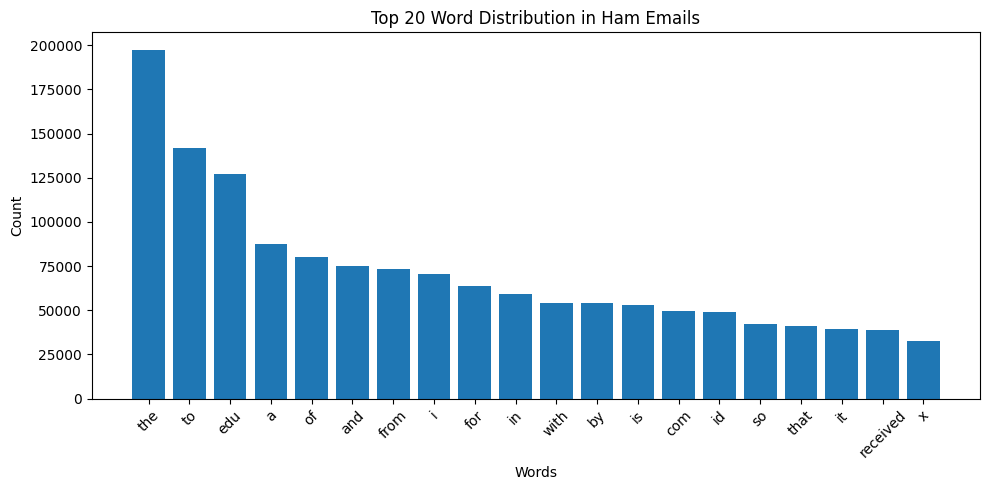

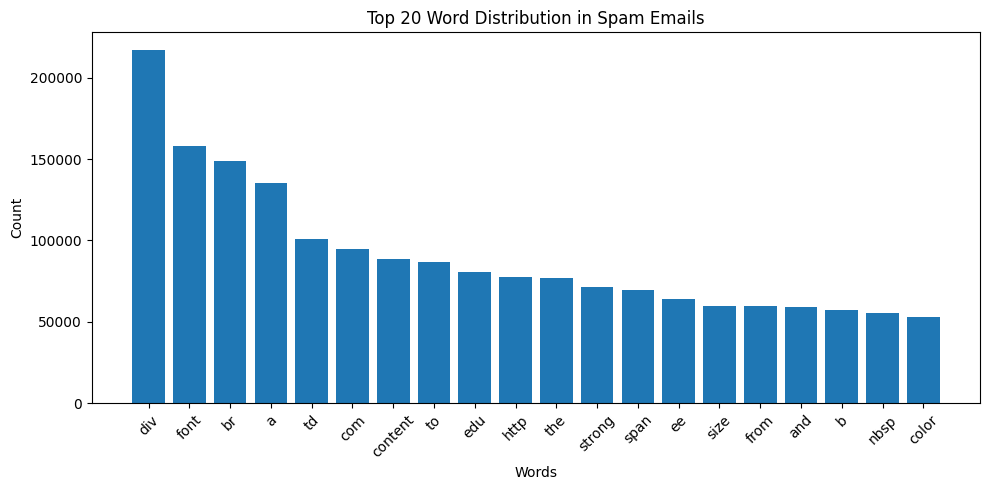

In [18]:
import matplotlib.pyplot as plt

# Set the number of top words to display
top_n = 20

# Plot the top words for ham emails
ham_top = ham_df.head(top_n)
plt.figure(figsize=(10, 5))
plt.bar(ham_top['word'], ham_top['count'])
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 20 Word Distribution in Ham Emails')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the top words for spam emails
spam_top = spam_df.head(top_n)
plt.figure(figsize=(10, 5))
plt.bar(spam_top['word'], spam_top['count'])
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 20 Word Distribution in Spam Emails')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Based on these charts, the most frequent words in ham emails are the common English words — likely articles, prepositions or conjunctions. These can be classified also as stop words. 

In contrast, the spam emails display the distribution where certain terms like HTML tags in order to create attention-grabbing design in their emails. Also another thing is that HTML allows them to cloud the content in ways that might bypass basic spam filters. 

This suggests that ham messages tend to use more standard, conversational vocabulary, while spam messages rely on tags to make them appear more flashy

### Training phase

This section computes the probability of each word given its class by first summing the total word counts for ham and spam from their respective Dataframes. 

Then we calculate P(word | class) by dividing each word's count by the total count for that class. 

In [ ]:
# Calculate each probability of each word given a class P(word | class)

total_ham_words = ham_df['count'].sum()
total_spam_words = spam_df['count'].sum()

# There is no laplace smoothing yet, if it is implemented then it will look like this: ham_df['P(word|ham)'] = (ham_df['count'] + alpha) / (total_ham_words + alpha * len(ham_vocabulary))
ham_df['P(word|ham)'] = (ham_df['count']) / total_ham_words
spam_df['P(word|spam)'] = spam_df['count'] / total_spam_words

ham_df

,word,count,P(word|ham)
0,the,197468,3.249377e-02
1,to,141665,2.331127e-02
2,edu,127371,2.095916e-02
3,a,87422,1.438547e-02
4,of,80018,1.316713e-02
...,...,...,...
137150,psicologia,1,1.645521e-07
137151,hebron,1,1.645521e-07
137152,pacifict,1,1.645521e-07
137153,versitility,1,1.645521e-07


## Create a Function to Predict the Class of a New Document

Note: use log to avoid underflow from multiplying many small probabilities.

### Without laplace smoothing

In this code, we convert the probability columns from the dataframes into dictionaries for faster lookup. Then the predict function uses log probabilities to compute the overall likelihood of an input document belonging to either the ham or spam class. 

It starts by taking the logarithm of the prior probabilities and then adds the logarithm of each word's conditional probability from the dictionaries for every token in the input document. 

Finally, we compare the accumulated log probabilities and return 'ham' or 'spam' based on which is higher. 

In [ ]:
import math

# Convert prob column to a dict for fast lookup
ham_probs = dict(zip(ham_df['word'], ham_df['P(word|ham)']))
spam_probs = dict(zip(spam_df['word'], spam_df['P(word|spam)']))


# Without laplace smoothing
def predict(input_document_tokens, prior_ham, prior_spam):
    log_prob_ham = math.log(prior_ham)
    log_prob_spam = math.log(prior_spam)

    total_ham_probs = log_prob_ham
    total_spam_probs =log_prob_spam

    
    for input_word in input_document_tokens:
        # Calculate for total_ham_probs
        if input_word in ham_probs:
            total_ham_probs += math.log(ham_probs[input_word])
        else:
            total_ham_probs += 0

        # Calculate for total_spam_probs
        if input_word in spam_probs:
            total_spam_probs += math.log(spam_probs[input_word])
        else:
            total_spam_probs += 0
    
    return 'ham' if total_ham_probs>total_spam_probs else 'spam'

### With laplace smoothing

In this code, we extend the classifier by incorporating the Laplace Smoothing to handle the unseen words during prediction. We start by defining the smoothing factor (alpha) in this case the 0.0000005 and the vocabulary size. 

Then, we update the conditional probability calculations for both ham and spam by adding alpha to each word count and adjusting the total accordingly. 

For each token, the function adds the logarithm of the appropriate probability if the word is present, or a smoothed probability if it isn't, and then returns the class with the higher total log probability.

In [19]:
# With laplace smoothing

alpha = 0.0000005
V = len(total_vocabulary)

ham_df['P(word|ham)'] = (ham_df['count']+alpha) / (total_ham_words + alpha*V)
spam_df['P(word|spam)'] = (spam_df['count']+alpha) / (total_spam_words + alpha*V)

ham_probs = dict(zip(ham_df['word'], ham_df['P(word|ham)']))
spam_probs = dict(zip(spam_df['word'], spam_df['P(word|spam)']))

def predict_with_laplace_smoothing(input_document_tokens, prior_ham, prior_spam):
    log_prob_ham = math.log(prior_ham)
    log_prob_spam = math.log(prior_spam)

    total_ham_probs = log_prob_ham
    total_spam_probs =log_prob_spam

    for input_word in input_document_tokens:
        # Calculate for total_ham_probs
        if input_word in ham_probs:
            total_ham_probs += math.log(ham_probs[input_word])
        else:
            smoothed_ham = (alpha) / (total_ham_words + alpha * V)
            total_ham_probs += math.log(smoothed_ham)

        # Calculate for total_spam_probs
        if input_word in spam_probs:
            total_spam_probs += math.log(spam_probs[input_word])
        else:
            smoothed_spam = (alpha) / (total_spam_words + alpha * V)
            total_spam_probs += math.log(smoothed_spam)
    
    return 'ham' if total_ham_probs>total_spam_probs else 'spam'

### Evaluation with laplace smoothing

Next, we prepare the test dataset and evaluate the classifier. We combine the ham and spam test emails into one list and construct the corresponding ground truth labels. Next, we tokenize the test documents using parse_documents. 

Lastly, we define and use a helper function that applies the Laplace-smoothed prediction to each tokenized document to generate the predicted labels. 

In [22]:
import math

# Evaluation

# Combine test texts
X_test = test_ham_texts + test_spam_texts
y_test = ['ham'] * len(test_ham_texts) + ['spam'] * len(test_spam_texts)

# Parse and tokenize the document:
parsed_input_docs = parse_documents(X_test)

# Predict multiple documents
def predict_documents(documents):
    return [predict_with_laplace_smoothing(document, prior_ham, prior_spam) for document in documents]

y_pred = predict_documents(parsed_input_docs)


Here, we have an example to test and predict using the laplace smoothing. We can add the sample email here and then the algorithm will predict if the email is spam or ham. 

In [23]:
# Example

# flatten/reshape the parsed_input_doc:
parsed_input_doc = parse_documents(["""Congratulations!

You’ve been chosen to receive an exclusive **$1000 Walmart Gift Card** — absolutely FREE! 🎉  
But hurry, this offer is only valid for the next 24 hours!

👉 Click here to claim your reward now: [http://claim-your-prize-now.xyz](http://claim-your-prize-now.xyz)  
(No purchase necessary!)

Act fast before this opportunity disappears forever.

Best wishes,  
The Rewards Team

P.S. This is a limited-time offer only available to select customers.
"""])

flattened_parsed_input_doc = parsed_input_doc[0]

predict_with_laplace_smoothing(flattened_parsed_input_doc, prior_ham, prior_spam)

'ham'

In this block, we evaluate the performance of the classifier on the test set. We calculate the overall accuracy, generate a confusion matrix (with 'ham' and 'spam' as labels) and compute the precision, recall and F1 score (treating 'spam' as the positive class). Finally, we print these metrics along with the full classification report. 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Accuracy
acc = accuracy_score(y_test, y_pred)


# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])


# Output
print("Accuracy:", acc)
print("Precision:", precision_score(y_test, y_pred, pos_label='spam'))
print("Recall:", recall_score(y_test, y_pred, pos_label='spam'))
print("F1 Score:", f1_score(y_test, y_pred, pos_label='spam'))

# Full classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9401483050847458
Precision: 0.9745798319327731
Recall: 0.933400402414487
F1 Score: 0.9535457348406988

Classification Report:
               precision    recall  f1-score   support

         ham       0.88      0.95      0.92      2582
        spam       0.97      0.93      0.95      4970

    accuracy                           0.94      7552
   macro avg       0.93      0.94      0.93      7552
weighted avg       0.94      0.94      0.94      7552



array([[2461,  121],
       [ 331, 4639]])

# Putting it all together using Classes

Here, we put it all together to define the NaiveBayesClassifier class to implement the entirety of the Naive Bayes Spam Filter with Laplace Smoothing. 

In [ ]:
import math 
from collections import Counter
from collections import defaultdict


class NaiveBayesClassifier:
    def __init__(self, alpha):
        """
        Initializes the classifier with a smoothing parameter lambda.
        """
        self.alpha = alpha
        self.ham_word_counts_dict = defaultdict(int) # word counts dictionary for ham class
        self.spam_word_counts_dict = defaultdict(int) # word counts dictionary for spam class
        self.ham_num_doc = 0
        self.spam_num_doc = 0
        self.ham_vocabulary = set()  # combined vocabulary for ham
        self.spam_vocabulary = set()  # combined vocabulary for spam
        self.vocabulary = set()  # combined vocabulary across classes
        self.fitted = False

    def fit(self, ham_docs, spam_docs):
        # Update document counts
        self.ham_doc_count = len(ham_docs)
        self.spam_doc_count = len(spam_docs)
        
        # Get vocabularies dictionaries (word:count) of each class
        # ham_docs and spam_docs are already tokenized/parsed ma dapat
        for doc in ham_docs:
            for word in doc:
                self.ham_word_counts_dict[word] += 1
                self.vocabulary.add(word)
                self.ham_vocabulary.add(word)
        for doc in spam_docs:
            for word in doc:
                self.spam_word_counts_dict[word] += 1
                self.vocabulary.add(word)
                self.spam_vocabulary.add(word)

        # Total words per class
        self.total_ham_words = sum(self.ham_word_counts_dict.values())
        self.total_spam_words = sum(self.spam_word_counts_dict.values())

        # Total words for all classes (ginagamit usually for smoothing itong si V)
        self.V = len(self.vocabulary)

        # Compute prior probabilities
        self.prior_ham = self.ham_doc_count/(self.ham_doc_count+self.spam_doc_count)
        self.prior_spam = self.ham_doc_count/(self.ham_doc_count+self.spam_doc_count)

        self.fitted = True

    def _calc_word_prob(self, word, class_word_counts, total_words):
        """
        Helper function to calculate the smoothed likelihood of a word 
        given a class.
        
        Parameters:
        word (str): The word to calculate probability for.
        class_word_counts (dict): Word Dictionary with counts for the given class.
        total_words (int): Total word count for the given class.
        
        Returns:
        laplace smoothed probability P(word|class).
        """
        word_count = class_word_counts[word]
        # Laplace smoothing: count + alpha divided by total words plus alpha * vocabulary size
        return (word_count + self.alpha) / (total_words + self.alpha * self.V)

        
    def get_unique_tokens(tokenized_docs):
        vocabulary = set()
        for doc in tokenized_docs:
            vocabulary.update(doc)
        return vocabulary
    
    def predict(self, input_document_token):
        """
        Predict the class ('ham' or 'spam') for a new document.
        
        Parameters:
        document_tokens (list of str): The tokenized document.
        
        Returns:
        str: Predic
        """
        if not self.fitted:
            raise Exception("Classifier not trained yet. Call fit() first.")
        
        log_prob_ham = math.log(self.prior_ham)
        log_prob_spam = math.log(self.prior_spam)

        total_ham_probs = log_prob_ham
        total_spam_probs =log_prob_spam

        for input_word in input_document_token:
            # Calculate for total_ham_probs
            if input_word in self.ham_word_counts_dict:
                word_ham_prob_smoothed = self._calc_word_prob(input_word, self.ham_word_counts_dict, self.total_ham_words)
                total_ham_probs += math.log(word_ham_prob_smoothed)
            else:
                smoothed_ham = (self.alpha) / (self.total_ham_words + self.alpha * self.V)
                total_ham_probs += math.log(smoothed_ham)

            # Calculate for total_spam_probs
            if input_word in self.spam_word_counts_dict:
                word_spam_prob_smoothed = self._calc_word_prob(input_word, self.spam_word_counts_dict, self.total_spam_words)
                total_spam_probs += math.log(word_spam_prob_smoothed)
            else:
                smoothed_spam = (self.alpha) / (total_spam_words + self.alpha * self.V)
                total_spam_probs += math.log(smoothed_spam)
        
        return 'ham' if total_ham_probs>total_spam_probs else 'spam'
    
    def predict_many(self, input_document_tokens):
        return [self.predict(doc) for doc in input_document_tokens]

        

Here, it initialize an instance of the NaiveBayesClassifier using a smoothing parameter (alpha) of 0.05. This value controls the amount of Laplace smoothing applied during training and prediction, helping to prevent zero probabilities for unseen words.

In [ ]:
# Initialize the model with some random lambda value
model = NaiveBayesClassifier(alpha=0.05)

Now we train the Naive Bayes classifier by calling its fit method with the tokenized ham and spam documents. This step updates the model with word frequencies, vocabulary, and document counts, preparing it for making predictions on unseen emails.

In [ ]:
# train/fit the model
model.fit(parsed_ham_docs, parsed_spam_docs)

Again, here is a test function to create a test email and identify whether it is a spam or ham email. 

In [109]:
# Example

# flatten/reshape the parsed_input_doc:
parsed_input_doc = parse_documents(["""Congratulations!

You’ve been chosen to receive an exclusive **$1000 Walmart Gift Card** — absolutely FREE! 🎉  
But hurry, this offer is only valid for the next 24 hours!

👉 Click here to claim your reward now: [http://claim-your-prize-now.xyz](http://claim-your-prize-now.xyz)  
(No purchase necessary!)

Act fast before this opportunity disappears forever.

Best wishes,  
The Rewards Team

P.S. This is a limited-time offer only available to select customers.
"""])

flattened_parsed_input_doc = parsed_input_doc[0]

model.predict(flattened_parsed_input_doc)

'ham'

Here, we evaluate the Naive Bayes Classifer with the same metrics as before. 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Combine test texts
X_test = test_ham_texts + test_spam_texts
y_test = ['ham'] * len(test_ham_texts) + ['spam'] * len(test_spam_texts)

# Parse and tokenize the document:
parsed_input_docs = parse_documents(X_test)


y_preds = model.predict_many(parsed_input_docs)

# Accuracy
acc = accuracy_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])

# Output
print("Accuracy:", acc)
print("Precision:", precision_score(y_test, y_pred, pos_label='spam'))
print("Recall:", recall_score(y_test, y_pred, pos_label='spam'))
print("F1 Score:", f1_score(y_test, y_pred, pos_label='spam'))

# Optional: Full classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Report
# report = classification_report(y_true, y_pred, labels=['ham', 'spam'])


Accuracy: 0.9401483050847458
Precision: 0.9745798319327731
Recall: 0.933400402414487
F1 Score: 0.9535457348406988

Classification Report:
               precision    recall  f1-score   support

         ham       0.88      0.95      0.92      2582
        spam       0.97      0.93      0.95      4970

    accuracy                           0.94      7552
   macro avg       0.93      0.94      0.93      7552
weighted avg       0.94      0.94      0.94      7552



In this block, we defined a helper function called compute_precision_recall that calculates the precision and recall metrics for my spam classifier. we assume that:

- TP (True Positives): Spam emails correctly predicted as spam.
- FP (False Positives): Ham emails misclassified as spam.
- FN (False Negatives): Spam emails misclassified as ham.

The function iterates over the true labels and predictions to count TP, FP, and FN. It then calculates precision and recall using these counts, ensuring that division by zero is avoided, and returns the computed values.

In [ ]:
# === Evaluation Metrics ===

def compute_precision_recall(y_true, y_pred):
    """
    Computes precision and recall given true labels and predictions.
    We assume:
        - TP: spam correctly classified as spam.
        - TN: ham correctly classified as ham.
        - FP: ham misclassified as spam.
        - FN: spam misclassified as ham.
    """
    tp = sum(1 for true, pred in zip(y_true, y_pred) if true == 'spam' and pred == 'spam')
    fp = sum(1 for true, pred in zip(y_true, y_pred) if true == 'ham' and pred == 'spam')
    fn = sum(1 for true, pred in zip(y_true, y_pred) if true == 'spam' and pred == 'ham')
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return precision, recall

Here, we evaluate how different Laplace smoothing parameters (lambda values) affect the classifier's performance. We first tokenize the test documents, then define a function **evaluate_with_lambdas**. 

- Iterates over a list of lambda values.
- For each lambda, creates a new classifier instance and fits it using the tokenized ham and spam training documents.
- Uses the trained classifier to predict labels on the test set.
- Computes precision and recall for the predictions using the helper function compute_precision_recall.
- Stores and prints the evaluation results for that lambda value.

Then we show the results for each of the lambda values. 

In [115]:
# Parse and tokenize the document:
parsed_test_docs = parse_documents(X_test)

def evaluate_with_lambdas(lambdas, parsed_ham_docs, parsed_spam_docs, test_docs, true_labels):
    results = {}

    for lam in lambdas:
        # Create a new classifier instance with the given lambda (smoothing parameter)
        nb_temp = NaiveBayesClassifier(alpha=lam)
        nb_temp.fit(parsed_ham_docs, parsed_spam_docs)  # using tokenized training documents
        
        # Predict on test set (assuming test_docs and true_labels are defined)
        predicted = nb_temp.predict_many(test_docs)
        prec, rec = compute_precision_recall(true_labels, predicted)
        
        results[lam] = {'precision': prec, 'recall': rec}
        print(f"Lambda: {lam} -> Precision: {prec:.4f}, Recall: {rec:.4f}")


lambdas = [2.0, 1.0, 0.5, 0.1, 0.005]
evaluate_with_lambdas(lambdas, parsed_ham_docs, parsed_spam_docs, parsed_test_docs, y_test)

Lambda: 2.0 -> Precision: 0.9550, Recall: 0.9052
Lambda: 1.0 -> Precision: 0.9600, Recall: 0.9119
Lambda: 0.5 -> Precision: 0.9622, Recall: 0.9167
Lambda: 0.1 -> Precision: 0.9661, Recall: 0.9294
Lambda: 0.005 -> Precision: 0.9697, Recall: 0.9352


These results show that as the lambda value decreases, both precision and recall improve. 

This indicates that using a smaller smoothing parameter—thus applying less artificial adjustment to the word counts—allows the model to better capture the actual distribution of words in the dataset, leading to more accurate spam detection. 

Although the improvements are gradual, they suggest that a lower lambda value produces a more sensitive and effective classifier for this particular task.

In this block, we calculate the "informative words" based on the log odds ratio of each word's likelihood in spam versus ham emails. 

For each word in the classifier's vocabulary, we compute its smoothed conditional probabilities in both classes and then calculate the log odds ratio (positive scores favor spam; negative scores favor ham). 

After sorting these scores by their absolute values to identify the most discriminative words, we extract the top 200 informative words. Finally, we separate and print the top 10 words that are most indicative of spam and the top 10 that are most indicative of ham.

In [ ]:
import math

def informative_words(classifier:NaiveBayesClassifier, top_n=200):
    """
    Computes the informative score (log-odds) for each word and returns the top_n words.
    Positive score: indicative of spam.
    Negative score: indicative of ham.
    """
    scores = {}
    for word in classifier.vocabulary:
        # Calculate P(word|class)
        p_spam = (classifier.spam_word_counts_dict[word] + classifier.alpha) / (classifier.total_spam_words + classifier.alpha * classifier.V)
        p_ham  = (classifier.ham_word_counts_dict[word]  + classifier.alpha)  / (classifier.total_ham_words  + classifier.alpha * classifier.V)
        # Compute log odds ratio
        score = math.log(p_spam / p_ham) # positive if p_spam is bigger (the word is more likely to be a spam), negative if p_ham is bigger (the word is more likely to be a ham)
        scores[word] = score
    # Sort words by the magnitude of the log odds ratio (most informative)
    sorted_words = sorted(scores.items(), key=lambda x: abs(x[1]), reverse=True)  # Sort by the absolute value of the score
    return sorted_words[:top_n]

# Use the best lambda from above 
nb_best = NaiveBayesClassifier(alpha=0.05)
nb_best.fit(parsed_ham_docs, parsed_spam_docs)

# get the top 200 informative words along with their scores.
top_informative = informative_words(nb_best, top_n=200)

# Separate into spam and ham lists:
spam_informative = [(word, score) for word, score in top_informative if score > 0]
ham_informative  = [(word, score) for word, score in top_informative if score < 0]

print("Top informative words for spam:")
print(spam_informative[:10])  # printing top 10 
print("Top informative words for ham:")
print(ham_informative[:10])


Top informative words for spam:
[('shopzilla', 11.43542166732738), ('greylink', 10.847642252650473), ('hoodia', 10.808383040199798), ('ephedra', 10.67150372415245), ('dgts', 10.624502779564844), ('edua', 10.60888420515285), ('anotherparty', 10.514238662240045), ('vipcollectvip', 10.482784437625622), ('writely', 10.470491429223157), ('yfti', 10.40766564015281)]
Top informative words for ham:
[('lugnet', -12.055427248315494), ('cert', -11.62611846471917), ('rpcss', -11.3925960721898), ('pdfzone', -11.27937657794656), ('pnfs', -11.194554718818175), ('patched', -11.189624633730942), ('reqs', -10.765040837629398), ('csf', -10.578989505723465), ('jforster', -10.548806437797001), ('mrc', -10.521547293806618)]


Next, we first create a set of the top 200 informative words based on their log odds scores. We then modify the prediction function to only consider tokens that belong to this informative vocabulary when classifying a document. 

Finally, we evaluate the classifier on the test set using this filtered vocabulary and compute the precision and recall, printing the resulting metrics.

In [ ]:
# Create a set of the top 200 informative words
informative_vocabulary = set([word for word, score in top_informative])

# Modifying the prediction function to ignore words not in informative_vocabulary:
def predict_with_informative(classifier, document_tokens, informative_vocabulary):
    # Only consider tokens that are in the informative vocabulary
    filtered_tokens = [word for word in document_tokens if word in informative_vocabulary]
    return classifier.predict(filtered_tokens)

# Evaluate on the test set using the filtered vocabulary:
def predict_many_informative(classifier, documents, informative_vocabulary):
    return [predict_with_informative(classifier, doc, informative_vocabulary) for doc in documents]

predicted_informative = predict_many_informative(nb_best, parsed_test_docs, informative_vocabulary)
prec_inf, rec_inf = compute_precision_recall(y_test, predicted_informative)
print("Using only informative words -> Precision: {:.4f}, Recall: {:.4f}".format(prec_inf, rec_inf))


Using only informative words -> Precision: 0.8008, Recall: 0.9895
